<div align="right">
Massimo Nocentini<br>
<br>September 8, 2016: synchronous fetching, drawing
</div>
<br>
<div align="center">
<b>Abstract</b><br>
This document describes our effort to perform mining techniques on the [OEIS][oeis].
</div>

[oeis]:http://oeis.org

# Built-in imports

The following cell import the function `oeis_search` in order to query the *Online Encyclopedia of Integer Sequences* and render search results directly in the current notebook; for a detailed tutorial, see http://nbviewer.jupyter.org/github/massimo-nocentini/competitive-programming/blob/master/tutorials/oeis-interaction.ipynb?flush_cache=true

In [1]:
from oeis import oeis_search

Follows `import`s required by this document.

In [2]:
from requests import get
import re
from itertools import count
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 20, 20

# Sandbox

## `asyncio`

Before starting coding, we collect an [interesting link][l].

[l]:http://sahandsaba.com/understanding-asyncio-node-js-python-3-4.html

In [3]:
import asyncio

### Simple examples using `event_loop`

Taken from https://docs.python.org/3.5/library/asyncio-eventloop.html#event-loop-examples

In [4]:

def hello_world(loop):
    print('Hello World')
    loop.stop()

loop = asyncio.get_event_loop()

# Schedule a call to hello_world()
loop.call_soon(hello_world, loop)

# Blocking call interrupted by loop.stop()
loop.run_forever()
print("before close")
loop.close()
print("after close")

Hello World
before close
after close


Taken from https://community.nitrous.io/tutorials/asynchronous-programming-with-python-3

In [ ]:

async def download(url, parts):
    async def get_partial_content(u, i, start, end):
        print(i, start, end)
        async with aiohttp.get(
                u, headers={"Range": "bytes={}-{}".format(start, end - 1 if end else "")}) as _resp:
            return i, await _resp.read()

    async with aiohttp.head(url) as resp:
        size = int(resp.headers["Content-Length"])

    ranges = list(range(0, size, size // parts))

    res, _ = await asyncio.wait(
        [get_partial_content(url, i, start, end) for i, (start, end) in
         enumerate(itertools.zip_longest(ranges, ranges[1:], fillvalue=""))])

    sorted_result = sorted(task.result() for task in res)
    return b"".join(data for _, data in sorted_result)


if __name__ == '__main__':
    image_url = "http://files.vladstudio.com/joy/where_tahrs_live/wall/vladstudio_where_tahrs_live_2880x1800_signed.jpg"
    loop = asyncio.get_event_loop()
    bs = loop.run_until_complete(download(image_url, 16))

    with open("test_para_async.jpeg", "wb") as fi:
        fi.write(bs)

### Asynchronous version

In [28]:
async def oeis_graph(seq_id, depth=2):
        
    sink = {}
    
    async def fetch(seq_id):
        print("fetching sequence {}".format(seq_id))
        payload = {"fmt": "json", "q": "id:A{:06d}".format(seq_id)}
        doc_result = get("https://oeis.org/search", params=payload,)
        doc = doc_result.json()
        return doc['results'].pop()

    def cross_references(xref):
        regex = re.compile('(?P<id>A\d{6,6})')
        return {int(r[1:]) for references in xref for r in regex.findall(references)}

    def not_seen_so_far(ref_seq_id):
            return ref_seq_id not in sink
    
    async def recursion(sequences, step):
        
        
            
        #res, _ = await asyncio.wait(
        #[get_partial_content(url, i, start, end) for i, (start, end) in
        # enumerate(itertools.zip_longest(ranges, ranges[1:], fillvalue=""))])

        #sorted_result = sorted(task.result() for task in res)
        #return b"".join(data for _, data in sorted_result)
            
        if step > depth: return sink

        print("\nFetching sequences:\n{} ".format(sequences))
        
        res, _ = await asyncio.wait([fetch(ref_seq_id)
                                     for i, ref_seq_id in zip(count(), sequences)
                                     #if i < 5 # to delete when we arrive at a working prototype
                                    ])
        
        cross_sequences = set()
        
        for task in res: 
            
            result = task.result()
            sink.update({seq_id: result}) # since `recursion` is called if `seq_id` hasn't been fetched

            # preparing for recursion
            result['xref_as_set'] = cross_references(result['xref']) if 'xref' in result else set()
            cross_sequences |= result['xref_as_set']
            
        return await recursion(set(filter(not_seen_so_far, cross_sequences)), step+1)
        
    return await recursion({seq_id}, step=0)
    

In [ ]:
loop = asyncio.get_event_loop()
bs = loop.run_until_complete(oeis_graph(seq_id=45, depth=3))

## Threading version - *use this one*

In [14]:
import threading
from multiprocessing.dummy import Pool as ThreadPool

def oeis_graph(seq_id, depth=2, workers=20):
        
    sink = {}
    
    def fetch(seq_id):
        payload = {"fmt": "json", "q": "id:A{:06d}".format(seq_id)}
        doc_result = get("https://oeis.org/search", params=payload,)
        #print("fetched sequence {}".format(seq_id))
        doc = doc_result.json()
        return doc['results'].pop()


    def cross_references(xref):
        regex = re.compile('(?P<id>A\d{6,6})')
        return {int(r[1:]) for references in xref for r in regex.findall(references)}#[:10]}

    def not_seen_so_far(ref_seq_id):
        return ref_seq_id not in sink
    
    def recursion(sequences, step):
        
        if step > depth: 
            print("Horizon reached.")
            return

        print("Fringe at distance {}, {} sequences to fetch.".format(step, len(sequences)))

        pool = ThreadPool(workers) # Make the Pool of workers

        # Open the urls in their own threads and return the results
        results = pool.map(fetch, sequences)

        #close the pool and wait for the work to finish
        pool.close()
        pool.join()

        cross_sequences = set()
        
        for result in results: 
            
            # since `recursion` is called if `seq_id` hasn't been fetched
            sink.update({int(result['number']): result}) 

            # preparing for recursion
            result['xref_as_set'] = cross_references(result['xref']) if 'xref' in result else set()
            cross_sequences |= result['xref_as_set']
            
        recursion(set(filter(not_seen_so_far, cross_sequences)), step+1)
        
    recursion({seq_id}, step=0)
    
    return sink
    

### An example using `ThreadPool`

Our implementation is inspired by the following example, taken from http://stackoverflow.com/questions/2846653/how-to-use-threading-in-python

In [7]:
%%time

import urllib.request
from multiprocessing.dummy import Pool as ThreadPool 

urls = [
  'http://www.python.org', 
  'http://www.python.org/about/',
  'http://www.onlamp.com/pub/a/python/2003/04/17/metaclasses.html',
  'http://www.python.org/doc/',
  'http://www.python.org/download/',
  'http://www.python.org/getit/',
  'http://www.python.org/community/',
  'https://wiki.python.org/moin/',
  ]

# Make the Pool of workers
pool = ThreadPool(4) 

# Open the urls in their own threads
# and return the results
results = pool.map(urllib.request.urlopen, urls)

#close the pool and wait for the work to finish 
pool.close() 
pool.join()


CPU times: user 210 ms, sys: 20 ms, total: 230 ms
Wall time: 1.31 s


In [8]:
results

## Synchronous version

In [7]:
def oeis_graph(seq_id, depth=2):
        
    sink = {}
    
    def recursion(seq_id, step):
        
        payload = {"fmt": "json", "q": "id:A{:06d}".format(seq_id)}
        doc_result = get("https://oeis.org/search", params=payload,)
        doc = doc_result.json()
        result = doc['results'].pop()

        sink.update({seq_id: result})

        # preparing for recursion
        xrefs = result['xref'][:10] if 'xref' in result else []

        cross_references = set()
        regex = re.compile('(?P<id>A\d{6,6})')
        for xref in xrefs:
            cross_references |= set(int(r[1:]) for r in regex.findall(xref))

        result['xref_as_set'] = cross_references
        print("\ncross references of sequence id {}:\n{} ".format(seq_id, cross_references))
            
        if step < depth:
            for i, ref_seq_id in zip(count(), filter(lambda cr: cr not in sink, cross_references)):
                if i > 4: break
                recursion(ref_seq_id, step+1)
        
    recursion(seq_id, step=0)
    
    return sink


# Use cases

In [45]:
def make_nx_graph(graph, summary=True):

    G=nx.DiGraph()

    G.add_nodes_from(graph.keys())

    for seq_id, v in graph.items():
        for ref_seq_id in filter(lambda r: r in graph, v['xref_as_set']):
            G.add_edge(seq_id, ref_seq_id)

    if summary:
        print("A graph with {} nodes and {} edges will be drawn".format(len(G.nodes()),len(G.edges())))
        
    return G

def draw_nx_graph(G, favorite_nodes):
    
    pos=nx.spring_layout(G)#, iterations=200) # positions for all nodes

    for seq_id, color_code in favorite_nodes.items():
        nx.draw_networkx_nodes(G, pos, nodelist=[seq_id], node_color=color_code, node_size=500, alpha=0.8)

    
    nx.draw_networkx_nodes(G,pos,
                           nodelist=set(G.nodes())-set(favorite_nodes.keys()),
                           node_color='r',
                           node_size=500,
                       alpha=0.8)
    
    nx.draw_networkx_edges(G,pos,width=1.0,alpha=0.5)
    
    plt.axis('off')
    plt.show()

In [42]:
fibonacci_seq_id, catalan_seq_id = 45, 108

## Fibonacci numbers 

In [27]:
fib_graph = oeis_graph(seq_id=fibonacci_seq_id, depth=2, workers=30)

Fringe at distance 0, 1 sequences to fetch.
Fringe at distance 1, 70 sequences to fetch.
Fringe at distance 2, 384 sequences to fetch.
Horizon reached.


In [43]:
G_fibonacci = make_nx_graph(fib_graph)

A graph with 455 nodes and 2193 edges will be drawn


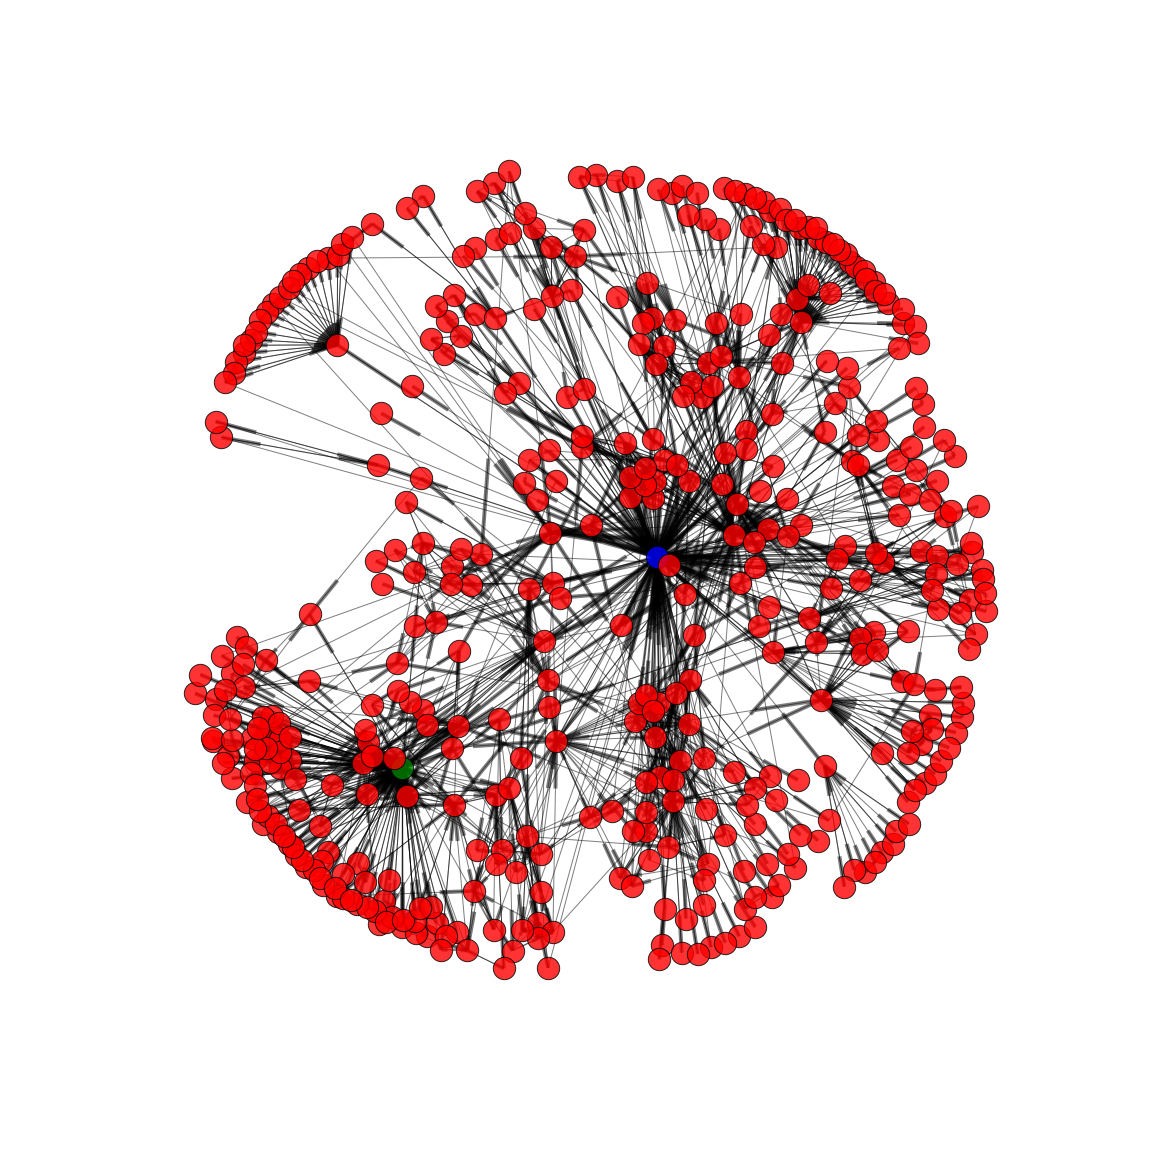

In [44]:
draw_nx_graph(G_fibonacci, favorite_nodes={fibonacci_seq_id:'b', catalan_seq_id:'g'})`

## Catalan numbers

In [47]:
catalan_graph = oeis_graph(seq_id=catalan_seq_id, depth=2, workers=30)

Fringe at distance 0, 1 sequences to fetch.
Fringe at distance 1, 77 sequences to fetch.
Fringe at distance 2, 317 sequences to fetch.
Horizon reached.


In [48]:
G_catalan = make_nx_graph(catalan_graph)

A graph with 395 nodes and 1424 edges will be drawn


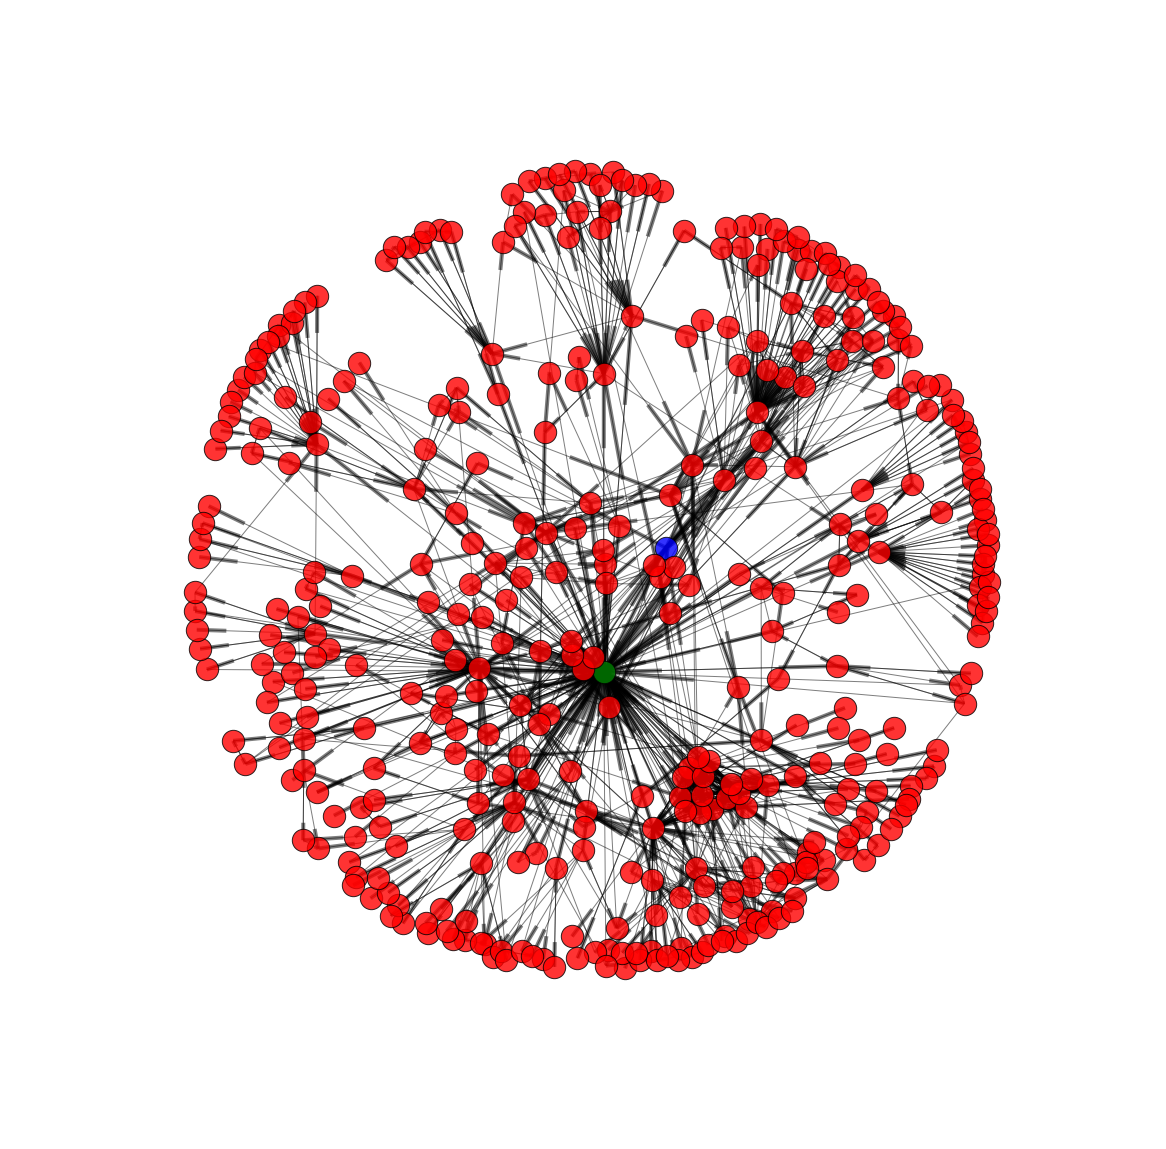

In [49]:
draw_nx_graph(G_catalan, favorite_nodes={fibonacci_seq_id:'b', catalan_seq_id:'g'})

## `networkx` example

Taken from the [official documentation][example].

[example]:https://networkx.github.io/documentation/networkx-1.10/examples/drawing/labels_and_colors.html

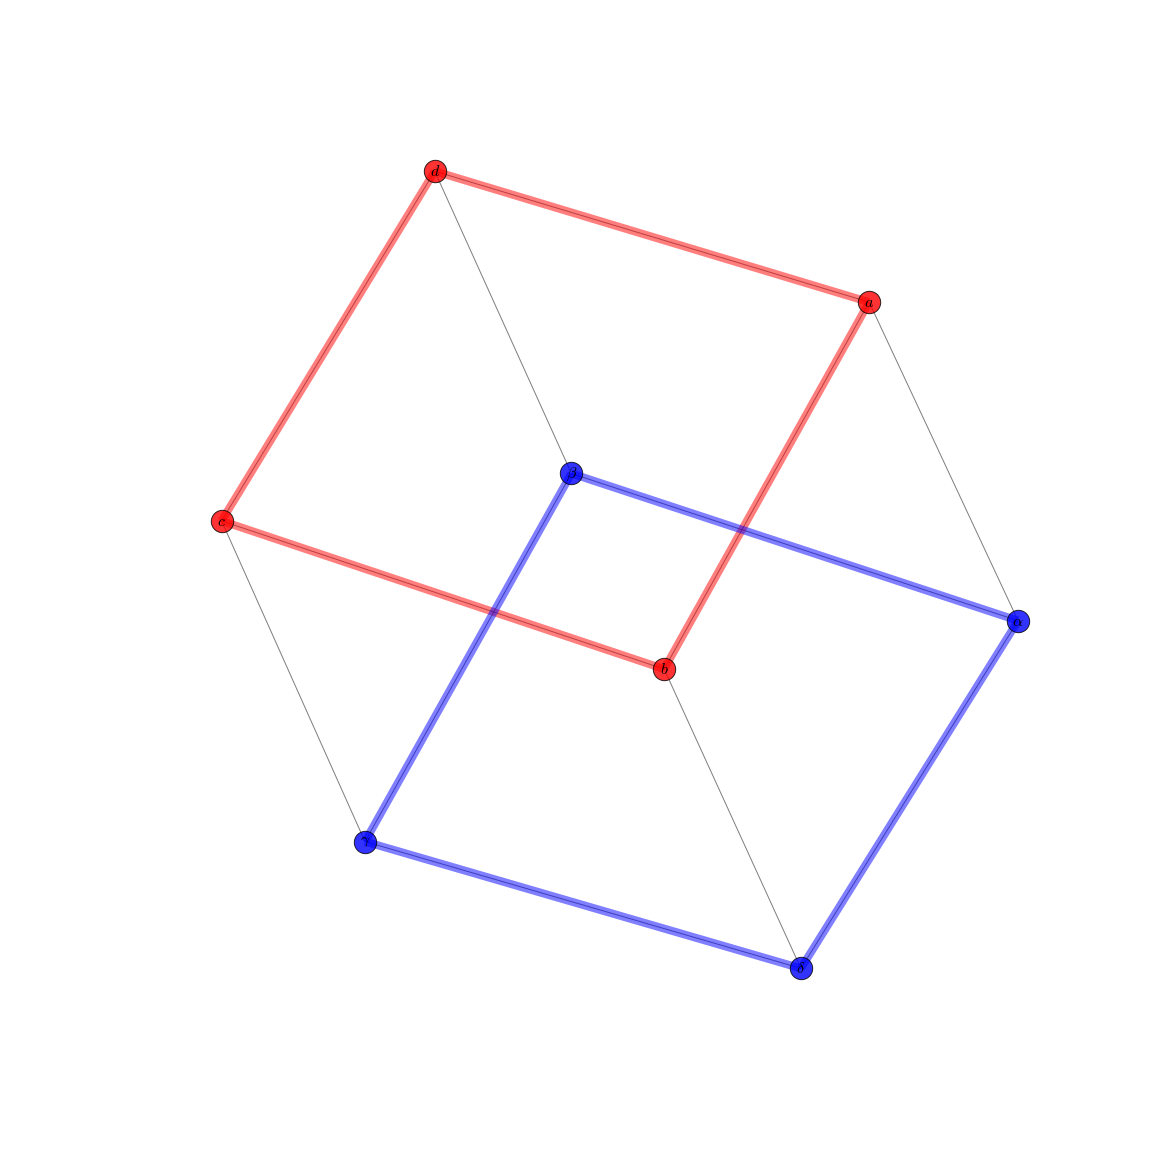

In [3]:

G=nx.cubical_graph()
pos=nx.spring_layout(G) # positions for all nodes

# nodes
nx.draw_networkx_nodes(G,pos,
                       nodelist=[0,1,2,3],
                       node_color='r',
                       node_size=500,
                   alpha=0.8)
nx.draw_networkx_nodes(G,pos,
                       nodelist=[4,5,6,7],
                       node_color='b',
                       node_size=500,
                   alpha=0.8)

# edges
nx.draw_networkx_edges(G,pos,width=1.0,alpha=0.5)
nx.draw_networkx_edges(G,pos,
                       edgelist=[(0,1),(1,2),(2,3),(3,0)],
                       width=8,alpha=0.5,edge_color='r')
nx.draw_networkx_edges(G,pos,
                       edgelist=[(4,5),(5,6),(6,7),(7,4)],
                       width=8,alpha=0.5,edge_color='b')


# some math labels
labels={}
labels[0]=r'$a$'
labels[1]=r'$b$'
labels[2]=r'$c$'
labels[3]=r'$d$'
labels[4]=r'$\alpha$'
labels[5]=r'$\beta$'
labels[6]=r'$\gamma$'
labels[7]=r'$\delta$'
nx.draw_networkx_labels(G,pos,labels,font_size=16)

plt.axis('off')
plt.savefig("labels_and_colors.png") # save as png
plt.show() # display

---
<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.